In [2]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils.utils import save_image_grid_with_labels, get_concept_index
import argparse
import numpy as np
from pathlib import Path
import yaml
import torch
from ast import literal_eval
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
from torch import nn
from models import cbae_stygan2 # ,cc_stygan2
from torchvision import transforms, models
from utils import gan_loss
import itertools
import warnings
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
# from eval.eval_intervention_gan import opt_int
import time

ImportError: cannot import name 'gan_loss' from 'utils' (e:\HLCV_Project\utils\__init__.py)

### Setup

* The next code block sets up the hyperparameters for the visualization.
* Use `optint=True` to use optimization-based interventions and `optint=False` for CB-AE interventions.
* Select target concept from:
    - Smiling
    - Mouth_Slightly_Open
    - Male
    - Arched_Eyebrows
    - Heavy_Makeup
    - High_Cheekbones
    - Wearing_Lipstick
    - Attractive
* Use `concept_value=1` for intervention target to be target concept (e.g. Smiling) and `concept_value=0` for opposite of target concept (e.g. Not Smiling).

In [2]:
# dataset to evaluate on
dataset = 'celebahq'
# experiment name
expt_name = 'cbae_stygan2_thr90'
# tensorboard name
tensorboard_name = 'sup_pl_unk40_cls8'
# whether to use optimization-based interventions
optint = True
optint_eps = 0.1
optint_iters = 50

# target concept and target value (desired concept to intervene on), e.g. "Smiling", "Mouth_Slightly_Open", "Male"
target_concept = 'Mouth_Slightly_Open'
## e.g. 0 or 1 (since all concepts in CelebA-HQ are binary)
concept_value = 0

clsf_model_type = 'rn18'
device = 'cuda:0'

### Load generative model with CB-AE

In [3]:
config_file = f"../config/{expt_name}/"+dataset+".yaml"

with open(config_file, 'r') as stream:
    config = yaml.safe_load(stream)
print(f"Loaded configuration file {config_file}")

Loaded configuration file ../config/cbae_stygan2_thr90/celebahq.yaml


In [4]:
num_cls = 8
set_of_classes = [
    ['NOT Attractive', 'Attractive'],
    ['NO Lipstick', 'Wearing Lipstick'],
    ['Mouth Closed', 'Mouth Slightly Open'],
    ['NOT Smiling', 'Smiling'],
    ['Low Cheekbones', 'High Cheekbones'],
    ['NO Makeup', 'Heavy Makeup'],
    ['Female', 'Male'],
    ['Straight Eyebrows', 'Arched Eyebrows']
]
conc_clsf_classes = [
    'Attractive',
    'Wearing_Lipstick',
    'Mouth_Slightly_Open',
    'Smiling',
    'High_Cheekbones',
    'Heavy_Makeup',
    'Male',
    'Arched_Eyebrows',
]

concept_change = conc_clsf_classes.index(target_concept)
config['model']['pretrained'] = '../models/checkpoints/stylegan2-celebahq-256x256.pkl'
model = cbae_stygan2.cbAE_StyGAN2(config)

cbae_ckpt_path = f'../models/checkpoints/{dataset}_{expt_name}_{tensorboard_name}_cbae.pt'

model.cbae.load_state_dict(torch.load(cbae_ckpt_path, map_location='cpu'))
model.to(device)
model.eval();

loading stylegan2 from ../models/checkpoints/stylegan2-celebahq-256x256.pkl
Total concepts (including unknown): 56
number of layers in CB-AE: 20


### Load concept classifier to evaluate concept interventions

In [5]:
if clsf_model_type == 'rn18':
    con_clsf = models.resnet18(weights='DEFAULT')
    num_features = con_clsf.fc.in_features
    con_clsf.fc = nn.Linear(num_features, 2) # binary classification (num_of_class == 2)
elif clsf_model_type == 'rn50':
    con_clsf = models.resnet50(weights='DEFAULT')
    num_features = con_clsf.fc.in_features
    con_clsf.fc = nn.Linear(num_features, 2) # binary classification (num_of_class == 2)
elif clsf_model_type == 'vit_l_16':
    con_clsf = models.vit_l_16(weights='ViT_L_16_Weights.IMAGENET1K_SWAG_E2E_V1')
    num_features = con_clsf.heads.head.in_features
    con_clsf.heads = nn.Linear(num_features, 2)

con_clsf.load_state_dict(torch.load(f'../models/checkpoints/{dataset}_{target_concept}_{clsf_model_type}_conclsf.pth', map_location='cpu'))
print(f'loading concept classifier from models/checkpoints/{dataset}_{target_concept}_{clsf_model_type}_conclsf.pth')
con_clsf = con_clsf.to(device)
con_clsf.eval()

tf_conclsf = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
if clsf_model_type == 'vit_l_16':
    ### generated by chatgpt
    class ResizeNormalizeTransform:
        def __init__(self, resize_size=(512, 512), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
            self.resize_size = resize_size
            self.normalize = transforms.Normalize(mean, std)

        def __call__(self, img_tensor):
            # Resize the tensor using interpolate (for BxCxHxW input)
            img_tensor = F.interpolate(img_tensor, size=self.resize_size, mode='bilinear', align_corners=False)
            # Normalize the tensor
            return self.normalize(img_tensor)

    tf_conclsf = ResizeNormalizeTransform()

loading concept classifier from models/checkpoints/celebahq_Mouth_Slightly_Open_rn18_conclsf.pth


### Perform concept interventions

In [6]:
batch_size = 16
num_steps = 20

orig_images_list = []
interv_images_list = []
for idx in tqdm(range(num_steps)):
    # intervene on one selected concept with selected value
    concept_change = concept_change
    concept_value = concept_value

    # Sample noise and labels as generator input
    z = torch.randn((batch_size, model.gen.z_dim), device=device)
    latent = model.gen.mapping(z, None, truncation_psi=1.0, truncation_cutoff=None)

    if optint:
        recon_latent = latent.detach().clone()
        new_latent = opt_int(model, latent, concept_change, concept_value, num_iters=optint_iters, eps=optint_eps, device=device)

    concepts = model.cbae.enc(latent)

    new_concepts = concepts.clone()

    start, end = get_concept_index(model, concept_change)
    c_concepts = concepts[:, start:end]
    _, num_c = c_concepts.shape

    # swapping the max value to the concept we need
    new_c_concepts = c_concepts.clone()
    old_vals = new_c_concepts[:, concept_value].clone()
    max_val, max_ind = torch.max(new_c_concepts, dim=1)
    new_c_concepts[:, concept_value] = max_val
    for swap_idx, (curr_ind, curr_old_val) in enumerate(zip(max_ind, old_vals)):
        new_c_concepts[swap_idx, curr_ind] = curr_old_val

    new_concepts[:, start:end] = new_c_concepts

    if not optint:
        new_latent = model.cbae.dec(new_concepts)
    recon_latent = model.cbae.dec(concepts)

    # Generate a batch of images
    gen_imgs_latent = model.gen.synthesis(new_latent, noise_mode='const')
    gen_imgs_latent_orig = model.gen.synthesis(recon_latent, noise_mode='const')

    gen_imgs_latent = gen_imgs_latent.mul(0.5).add_(0.5)
    gen_imgs_latent_orig = gen_imgs_latent_orig.mul(0.5).add_(0.5)

    # converting it to the normalization required by ResNet18 concept classifier
    gen_imgs_latent_cc = tf_conclsf(gen_imgs_latent)
    gen_imgs_latent_orig_cc = tf_conclsf(gen_imgs_latent_orig)

    interv_pred = con_clsf(gen_imgs_latent_cc).argmax(dim=1)
    recon_pred = con_clsf(gen_imgs_latent_orig_cc).argmax(dim=1)

    # pick out samples which do not have the desired concept value (to see change with intervention)
    curr_mask = (recon_pred != concept_value)
    if gen_imgs_latent.data[curr_mask].numel() != 0:
        orig_imgs = save_image_grid_with_labels(gen_imgs_latent_orig.data[curr_mask], recon_pred[curr_mask], set_of_classes[concept_change], grid_size=(4, 4), file_name=None, return_images=True).detach().cpu()
        interv_imgs = save_image_grid_with_labels(gen_imgs_latent.data[curr_mask], interv_pred[curr_mask], set_of_classes[concept_change], grid_size=(4, 4), file_name=None, return_images=True).detach().cpu()
        orig_images_list.append(orig_imgs)
        interv_images_list.append(interv_imgs)

orig_images = torch.cat(orig_images_list, dim=0)
interv_images = torch.cat(interv_images_list, dim=0)

orig_grid = make_grid(orig_images[:64], nrow=8, padding=2, normalize=True)
interv_grid = make_grid(interv_images[:64], nrow=8, padding=2, normalize=True)

  0%|                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:34<00:00,  1.72s/it]


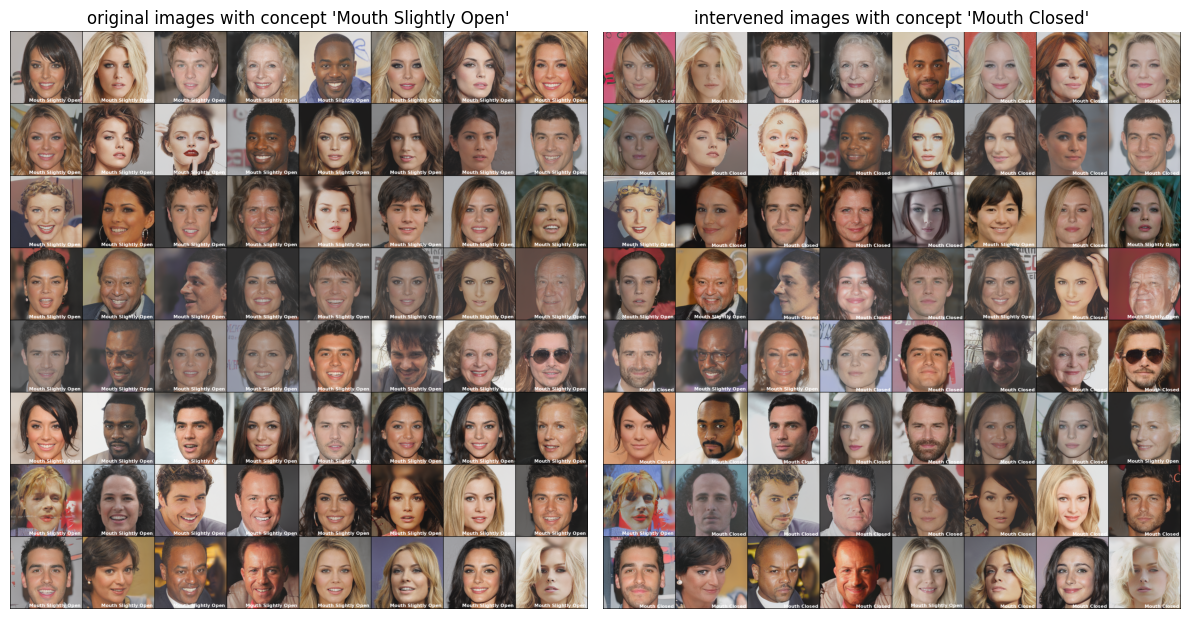

In [7]:
def imshow_grid(grid, title, ax):
    # Convert from torch tensor to numpy image
    npimg = grid.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))  # CHW to HWC
    ax.imshow(npimg)
    ax.set_title(title)
    ax.axis('off')

fig, axs = plt.subplots(1, 2, figsize=(12, 12))

imshow_grid(orig_grid, f"original images with concept \'{set_of_classes[concept_change][1 - concept_value]}\'", axs[0])
imshow_grid(interv_grid, f"intervened images with concept \'{set_of_classes[concept_change][concept_value]}\'", axs[1])

plt.tight_layout()
plt.show()